In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn

Reproductibility seed

In [3]:
MANUAL_SEED = 42

torch.manual_seed(MANUAL_SEED) #this sets the reproductibility seed for pytorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Preparing Dataset

In [152]:
import torchvision.transforms.v2 as transforms

initial_transform = transforms.Compose([
    transforms.Resize((64,64)), #Force the resize of the image before transforming to tensor, the size depends of the business case
    transforms.ToImage(), #converts from PIL to tensor(C,H,W)
    transforms.ToDtype(torch.float32, scale=True)]) #converts to float32 and scales to 0-1
    

#ToTensor() is deprecated instead we have to use ToImage + ToDtype

In [153]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FruitDataset(Dataset):
    def __init__(self, dataframe, img_dir, labels=True, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform

        if labels:
            #Create a list with all the classes
            classes = self.data['Label'].unique()
            #Create an index mapping for each label
            self.class_idx_map = {cls: idx for idx,cls in enumerate(classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if self.labels:
            image_path = os.path.join(self.img_dir,self.data.iloc[idx]['filename'])
            image = Image.open(image_path).convert('RGB')
            label = self.data.iloc[idx]['Label']
        else:
            image_path = os.path.join(self.img_dir,self.data.iloc[idx]['filename'])
            image = Image.open(image_path).convert('RGB')
            label = None

        #Applies the transforms to the image
        if self.transform is not None:
            image = self.transform(image)
        
        #Ensures tensors are properly detach and typecasted
        #As this was read as an image is not necesary to make anything
        image_tensor = image
        
        #retrieves the index of the label corresponding to the mapping with class index
        label_idx = self.class_idx_map[label]
        label_tensor = torch.tensor(label_idx).clone().detach().long()
    
        return image_tensor, label_tensor

In [154]:
train_img_folder = '/kaggle/input/fruit-classification/train/train/'
fruit_dataframe = pd.read_csv('/kaggle/input/fruit-classification/train.csv')
fruit_dataframe.rename(columns={'Id':'filename'},inplace=True) #Renames the column name

dataset = FruitDataset(fruit_dataframe,train_img_folder,labels=True,transform=initial_transform)

Verifying if we are retrieving the image correctly

torch.Size([3, 64, 64])


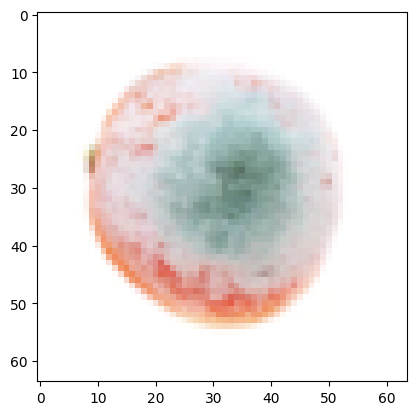

In [155]:
import matplotlib.pyplot as plt

first_image, first_label = dataset[0]
print(first_image.shape)

#to show the image we have to conver from (C, H, W) to (H, W, C) which is expected by matplotlib
plt.imshow(first_image.permute(1,2,0))

In [156]:
arr = np.array(first_image)
arr.shape

(3, 64, 64)

In [158]:
arr[0][10:50,:]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [163]:
dataset[0][0].min(),dataset[0][0].max()

(tensor(0.2784), tensor(1.))

### Create train - validation dataframe splits

In [ ]:
'''validation_size = int(0.25 * len(dataset))
train_size = len(dataset) - validation_size
valid_subset, train_subset = torch.utils.data.random_split(
    dataset, [validation_size,train_size], generator = torch.Generator().manual_seed(42)
)
'''

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    fruit_dataframe,
    test_size = 0.2,
    stratify = train_df['Label'],
    random_state = MANUAL_SEED
)

### Create train - validation sets

In [ ]:
train_dataset = FruitDataset(train_df,train_img_folderlabels=True,transform=initial_transform)
valid_dataset = FruitDataset(valid_df,train_img_folderlabels=True,transform=initial_transform)

print('Train dataset lenght:',len(train_dataset))
print('Valid dataset lenght:',len(valid_dataset))

### Create Dataloaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_subset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_subset,batch_size=batch_size)

images, labels = next(iter(train_loader))
images.shape, labels.shape


In [ ]:

class MyCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)

        self.fc1 = nn.Linear(16*5*5,128)
        self.fc2 = nn.Linear(128,84)
        self.fc3 = nn.Linear(84,num_classes)

    def forward(self, x):
        #Original Image Input -> [channels=3,64,64]
        x = F.relu(self.conv1(x)) #->[channels=16,64,64]
        x = self.pool(x) #->[channels=16,32,32]
        x = F.relu(self.conv2(x)) #->[channels=32,32,32]
        x = self.pool(x) #->[channels=32,16,16]
        x = x.view(x.size(0), -1) # flatten ->[32 * 16 * 16] = [8192]
        x = F.relu(self.fc1(x)) #->[128]
        x = F.relu(self.fc2(x)) #->[84]
        x = self.fc3(x) # Number of classes ->[6]
        return x

model = MyCNN(num_classes = 6)

In [ ]:
#Sends the model to the GPU
model.to(device)

### Loss Function and Optimizer

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

### Compute Accuracy

In [ ]:
def get_batch_accuracy(output,y):
    pred = output.argmax(dim=1,keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct/output.shape[0]

In [ ]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


In [ ]:
def train():
    total_losses = 0
    total_accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        ouput = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output,y)
        batch_loss.backward()
        optimizer.step()

        total_loss +=batch_loss_item()
        total_accuracy += get_batch_accuracy(output, y)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

    print('Train - Loss: {} Accuracy: {}'.format(avg_loss, avg_accuracy))

    return avg_loss, avg_accuracy

In [ ]:
def validate():
    total_loss = 0
    total_accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            batch_loss = loss_function(output, y)
            total_loss += batch_loss_item()
            total_accuracy += get_batch_accuracy(output, y)

    avg_loss = total_loss / len(valid_loader)
    avg_accuracy = total_accuracy / len(valid_loader)

    valid_losses.append(avg_loss)
    valid_accuracies.append(avg_accuracy)

    print('Valid - loss: {} Accuracy: {}'.format(avg_loss,avg_accuracy))

    return avg_loss, avg_accuracy

In [ ]:
def get_training_config():
    config = {
        'learning_rate': 0.01,
        'weight_decay': 1e-4,
        'epochs': 3,
        'min_lr': 1e-6
    }
    return config

config = get_training_config()

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)